# Comparing Random vs Non Random data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [6]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds
from hard_rules import denoised_fraction, version_serializtion

In [7]:
data = pd.read_parquet("../Data/random_10k.parquet")

In [8]:
data = data[data["maid"]=='7']

## Filtering
1. Non houses 
2. Cookies with mixed constant 
3. Cookies which are assigned to a house which they do not apepar in

In [9]:
data = data[data['is_hh']]

In [10]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [11]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [12]:
equal_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

In [13]:
mixed_iiqids = more_than_5.index.get_level_values(level=1).to_list()

In [14]:
data = data[~data['iiqid'].isin(mixed_iiqids)]

In [15]:
misplaced_series = ~data.groupby('iiqid')['is_house_ip_or_source_ip'].any()
misplaced_iiqids = misplaced_series[misplaced_series].index.values

In [16]:
data = data[~data['iiqid'].isin(misplaced_iiqids)]

## Creating relevant tables
- Random pairs
- Cookies time data
- Cookies version noise data

In [17]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [18]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [19]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [20]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [21]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [22]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [23]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [24]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [25]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [26]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [27]:
cookie_time = data.groupby('iiqid')['time'].agg(['min', 'max'])

In [28]:
cookie_time['interval'] = (cookie_time['max'] - cookie_time['min']).apply(lambda t: t.days)

In [29]:
noises = data.groupby('iiqid').apply(denoised_fraction)

In [30]:
noises = noises.rename('noise')

### A single pair

- Time interval first
- Time interval second
- Time between end first and start second(maybe after remove outliers)
- Time interval we looked at (can check options)
- Number of points min
- Number of points max
- UA version error
- Overlap errors that we calculate

In [31]:
random_cookie_1 = np.random.choice(data['iiqid'].unique())
random_cookie_2 = np.random.choice(data['iiqid'].unique())

In [32]:
size1 = len(data[data['iiqid']==random_cookie_1])
size2 = len(data[data['iiqid']==random_cookie_2])

In [33]:
single_row = pd.DataFrame({'id1': [random_cookie_1], 'id2': [random_cookie_2], 
              'min_size': min(size1, size2), 'max_size':max(size1, size2)})

In [34]:
single_row = single_row.merge(cookie_time, left_on='id1', right_index=True)
single_row = single_row.merge(cookie_time, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [35]:
single_row = single_row.merge(noises, left_on='id1', right_index=True)
single_row = single_row.merge(noises, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [36]:
single_row

,id1,id2,min_size,max_size,min_id1,max_id1,interval_id1,min_id2,max_id2,interval_id2,noise_id1,noise_id2
0,8UpRRCayYz,ipQoowp6Cz,37,47,2022-12-02 02:05:01.093,2023-02-27 01:12:23.949,86,2022-12-09 01:13:20.539,2023-02-21 03:57:00.791,74,1.0,1.0


### Random Data

In [37]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/2102 [00:00<?, ?it/s]

In [38]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [39]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [40]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [41]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [42]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [43]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,2102.0,0.155593,0.138640,0.000000,0.031842,0.121096,0.25,0.5
size_0,2102.0,56.226927,101.195930,1.000000,4.000000,19.000000,63.00,1514.0
size_1,2102.0,56.899144,117.877591,1.000000,5.000000,20.000000,62.00,2460.0
interval_0,2102.0,46.409610,33.658392,0.000000,8.000000,53.000000,80.00,88.0
interval_1,2102.0,46.582778,33.242744,0.000000,10.000000,53.000000,79.00,88.0
vers_clean_0,2102.0,0.996031,0.019213,0.500000,1.000000,1.000000,1.00,1.0
vers_clean_1,2102.0,0.996844,0.013097,0.818182,1.000000,1.000000,1.00,1.0
min_size,2102.0,20.189819,37.839734,1.000000,2.000000,6.000000,22.00,518.0
max_size,2102.0,92.936251,141.622181,1.000000,17.000000,49.000000,116.00,2460.0
min_interval,2102.0,30.363939,30.824020,0.000000,0.000000,21.000000,60.00,88.0


<AxesSubplot: >

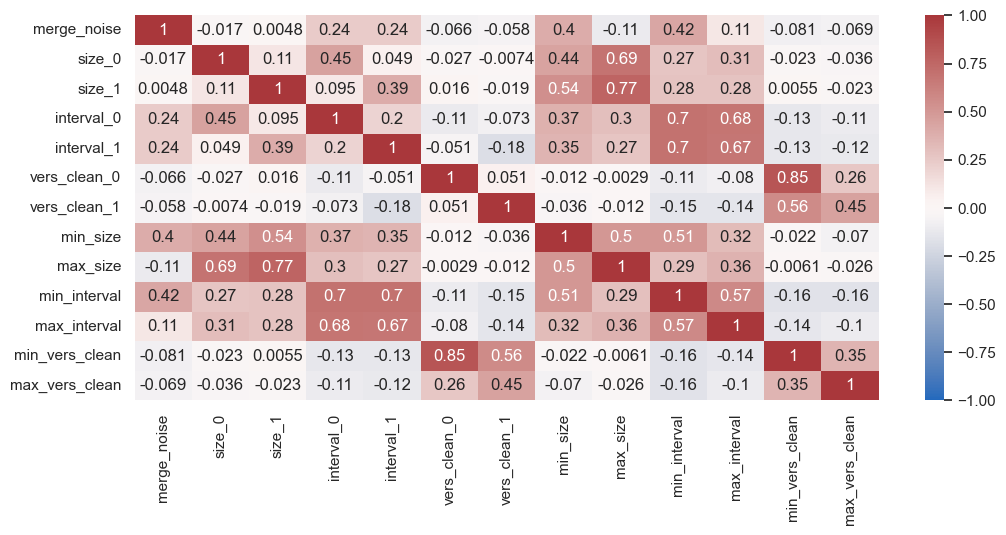

In [44]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [45]:
# mins = random_trial_data[features].min()
# maxs = random_trial_data[features].max()

In [46]:
# random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1), 'merge_noise'].mean()

In [47]:
# matrix = []
# for s in range(1, 30):
#     row = []
#     for i in range(14):
#         row.append(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1), 
#                                          'merge_noise'].mean())
#     matrix.append(row)

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [48]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [49]:
# features
thresholds = [3, 7, 0.5]
noise_thresh = 0.1

In [50]:
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.2686084142394822


In [51]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

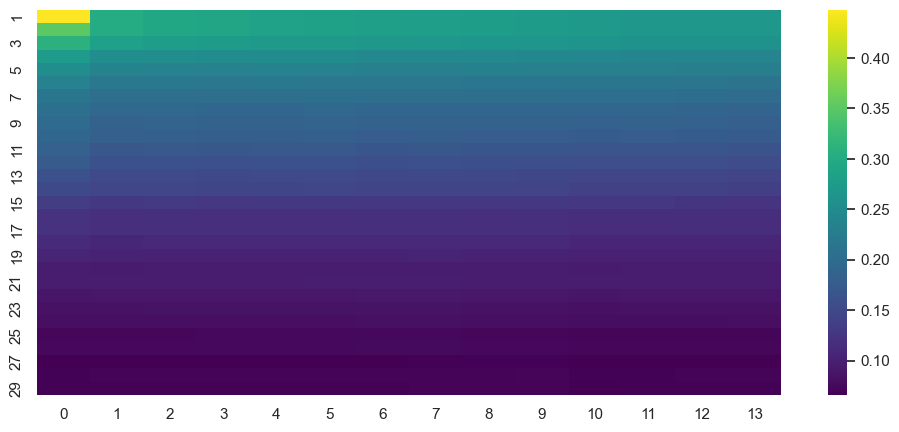

In [52]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

## Non-Random Data

In [53]:
more_than_one_cooke = data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [54]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [55]:
brothers_paris = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_paris.columns = ['first','second']

In [56]:
i = 0
iiqid_0, iiqid_1 = trial_pairs.iloc[i].values
print(iiqid_0, iiqid_1)

gN9XYNAcKB pQNzO10U6M


In [57]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for i in tqdm(brothers_paris.index):
    iiqid_0, iiqid_1 = brothers_paris.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/2364 [00:00<?, ?it/s]

In [58]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [59]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [60]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [61]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [62]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [63]:
random_trial_data2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,2364.0,0.102951,0.146004,0.000000,0.0,0.0,0.197409,0.5
size_0,2364.0,44.131557,88.875712,1.000000,3.0,12.0,47.000000,1299.0
size_1,2364.0,46.812606,108.552964,1.000000,3.0,14.0,48.000000,3223.0
interval_0,2364.0,38.706430,34.282157,0.000000,0.0,36.0,75.000000,88.0
interval_1,2364.0,39.494924,34.280717,0.000000,0.0,39.0,76.000000,88.0
vers_clean_0,2364.0,0.997101,0.015678,0.642857,1.0,1.0,1.000000,1.0
vers_clean_1,2364.0,0.996701,0.016342,0.714286,1.0,1.0,1.000000,1.0
min_size,2364.0,29.416667,64.569805,1.000000,2.0,8.0,28.000000,1048.0
max_size,2364.0,61.527496,122.479399,1.000000,5.0,21.0,75.250000,3223.0
min_interval,2364.0,31.837563,32.747561,0.000000,0.0,21.0,65.000000,88.0


In [89]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

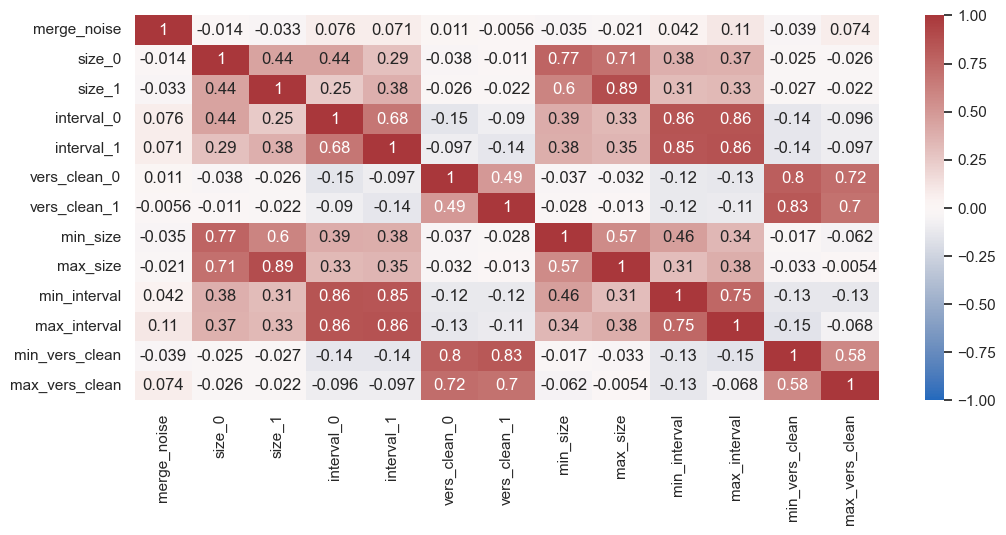

In [91]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [65]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [66]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

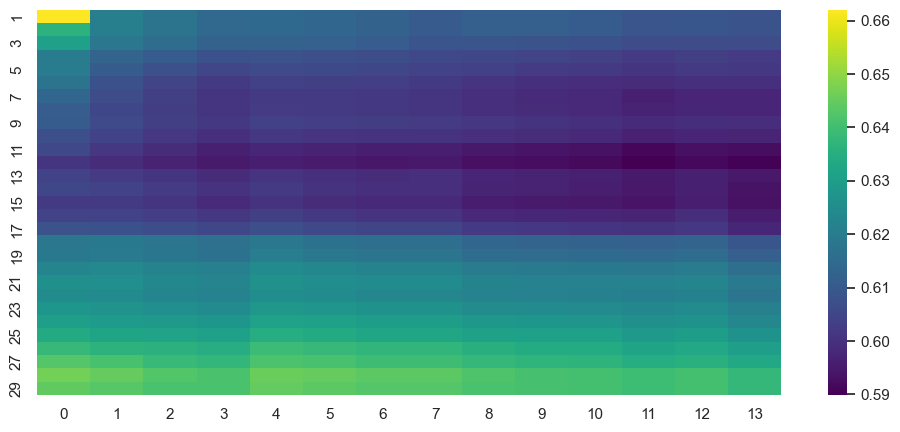

In [67]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

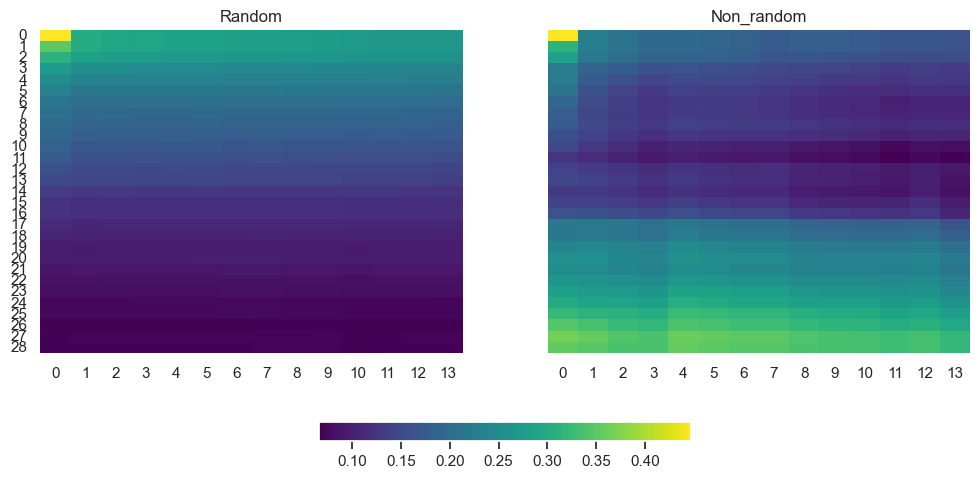

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [69]:
matrix_part = [m[:10] for m in matrix[:10]]
matrix2_part = [m[:10] for m in matrix2[:10]]

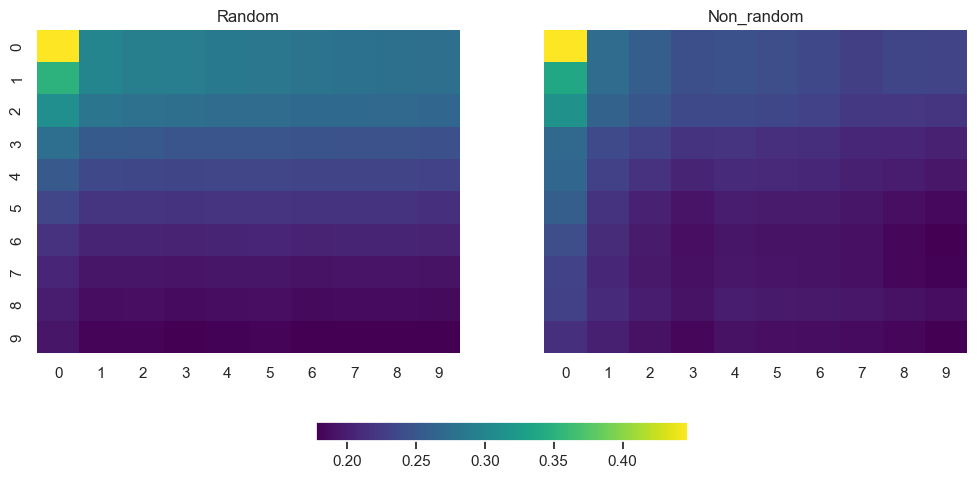

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix_part, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2_part, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [71]:
s = 20
i = 14
len(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)])

540

In [72]:
matrix_test = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(total_above_thresh))
    matrix_test.append(row)

In [73]:
min(min(matrix_test))

555

Text(0.5, 1.0, 'Non-Random')

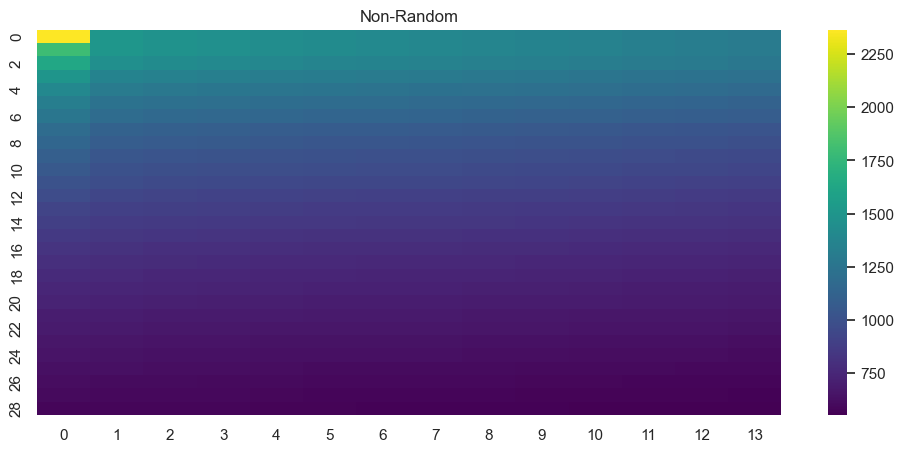

In [74]:
sns.heatmap(matrix_test, cmap='viridis')
plt.title("Non-Random")

## GridSearch

In [75]:
def good_cookies_above_thresh(df, min_interval, min_size, min_vers_clean, merge_noise):
    total_above_thresh = df.loc[(df[features] >= [min_size, min_interval, min_vers_clean]).all(axis=1)]
    good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < merge_noise]
    return len(good_aobve_thresh)/len(total_above_thresh)

In [105]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize variables to keep track of the best parameter values and the largest difference
best_diff_params = None
best_ratio_params = None
largest_difference = None
largest_ratio = None

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    
    # Check if the current parameter values give a larger difference than the previous best
    if largest_difference is None or difference > largest_difference:
        largest_difference = difference
        best_diff_params = param_values

    if largest_ratio is None or ratio > largest_ratio:
        largest_ratio = ratio
        best_ratio_params = param_values

# Print the best parameter values and the largest difference
print("Best difference parameters:", {k: round(v, 3) for k,v in best_diff_params.items()})
print("Largest difference:", largest_difference)
print("Best ratio parameters:", {k: round(v, 3) for k,v in best_ratio_params.items()})
print("Largest ratio:", largest_ratio)

  0%|          | 0/5000 [00:00<?, ?it/s]

Best difference parameters: {'min_interval': 10, 'min_size': 9, 'min_vers_clean': 1.0, 'merge_noise': 0.02}
Largest difference: 0.5523369691343699
Best ratio parameters: {'min_interval': 9, 'min_size': 9, 'min_vers_clean': 0.722, 'merge_noise': 0.02}
Largest ratio: 0.9761956337071016


In [108]:
result_diff = {k: round(v, 3) for k,v in best_diff_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_diff_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_diff_params)
pd.DataFrame(result_diff, index=['best'])

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random
best,10,9,1.0,0.02,0.017986,0.570323


In [109]:
result_diff = {k: round(v, 3) for k,v in best_ratio_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_ratio_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_ratio_params)
pd.DataFrame(result_diff, index=['best'])

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random
best,9,9,0.722,0.02,0.012615,0.529931


In [118]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [132]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [133]:
results_df.sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
4260,9,9,0.611111,0.02,0.012615,0.529931,0.517317,0.976196
4614,9,9,0.722222,0.02,0.012615,0.529931,0.517317,0.976196
2867,9,9,0.666667,0.02,0.012615,0.529931,0.517317,0.976196
2087,9,9,0.777778,0.02,0.012615,0.529931,0.517317,0.976196
2103,9,9,0.833333,0.02,0.012673,0.529931,0.517258,0.976086
3139,10,9,0.611111,0.02,0.012687,0.530049,0.517362,0.976064
4655,10,9,0.500000,0.02,0.012687,0.530049,0.517362,0.976064
1938,10,9,0.833333,0.02,0.012746,0.530049,0.517303,0.975953
3082,10,9,0.833333,0.02,0.012746,0.530049,0.517303,0.975953
3687,10,9,0.833333,0.02,0.012746,0.530049,0.517303,0.975953


<AxesSubplot: >

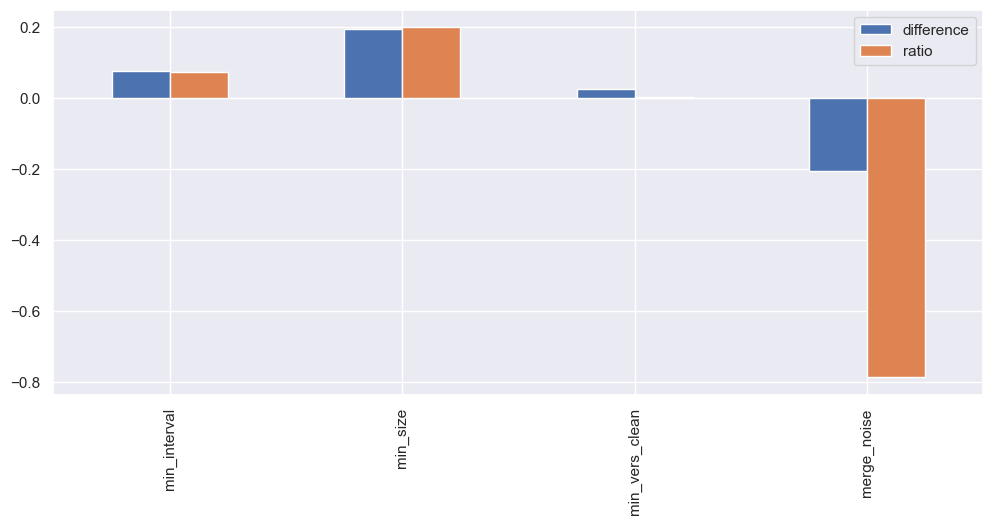

In [138]:
results_df.corr()[['difference', 'ratio']][:4].plot.bar()

## Restrict by longest living cookie

In [245]:
def longest_sequence(df, name_str='id', start_str='start', end_str='end'):
    # Sort dataframe by start time
    df = df.sort_values(by=start_str)

    # Initialize dictionary to keep track of longest sequences
    # ending with each id
    seq_lengths = {i: e - s for i, s, e in df[[name_str, start_str, end_str]].values}
    
    # Initialize dictionary to keep track of the previous id
    # in the longest sequence ending with each id
    prev_ids = {i: None for i in df[name_str].values}

    for i in range(len(df)):
        curr_row = df.iloc[i]
        for j in range(i):
            prev_row = df.iloc[j]
            curr_interval = curr_row[end_str] - prev_row[end_str]
            if prev_row[end_str] <= curr_row[end_str] and prev_row[end_str] >= curr_row[start_str]:
                if seq_lengths[curr_row[name_str]] < seq_lengths[prev_row[name_str]] + curr_interval:
                   seq_lengths[curr_row[name_str]] = seq_lengths[prev_row[name_str]] + curr_interval
                   prev_ids[curr_row[name_str]] = prev_row[name_str]

    # Find id with longest sequence ending with it
    end_id = max(seq_lengths, key=seq_lengths.get)

    # Reconstruct longest sequence
    seq = []
    while end_id is not None:
        seq.insert(0, end_id)
        end_id = prev_ids[end_id]

    return seq

In [246]:
def plot_intervals(df, name_str='id', start_str='start', end_str='end', color='blue', highlight_ids=None, highlight_color='red'):
    # Create a horizontal bar chart with the intervals for each row
    fig, ax = plt.subplots(figsize=(8, 3))
    for i, row in df.iterrows():
        id = row[name_str]
        start = row[start_str]
        end = row[end_str]
        if highlight_ids and id in highlight_ids:
            ax.broken_barh([(start, end - start)], (i, 1), label=id, facecolors=highlight_color)
        else:
            ax.broken_barh([(start, end - start)], (i, 1), label=id, facecolors=color)
    
    # Add legend and axis labels
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Time')
    ax.set_ylabel('Row')
    
    # Show the plot
    plt.show()


In [190]:
df = cookie_time.head(15).reset_index().sort_values(by='min')

In [191]:
# for i in range(len(df)):
    # print(df[['iiqid', 'min', 'max']].iloc[i].values)
    
# for i, j, k in df[['iiqid', 'min', 'max']].values:
#     print(k)

In [248]:
longest_sequence(cookie_time.sample(15).reset_index(), name_str='iiqid', start_str='min', end_str='max')

['EKYVonJIF7', 'VI2muas0Pw']

In [236]:
shots = cookie_time[(5 < cookie_time['interval']) & (cookie_time['interval'] < 20)].reset_index()

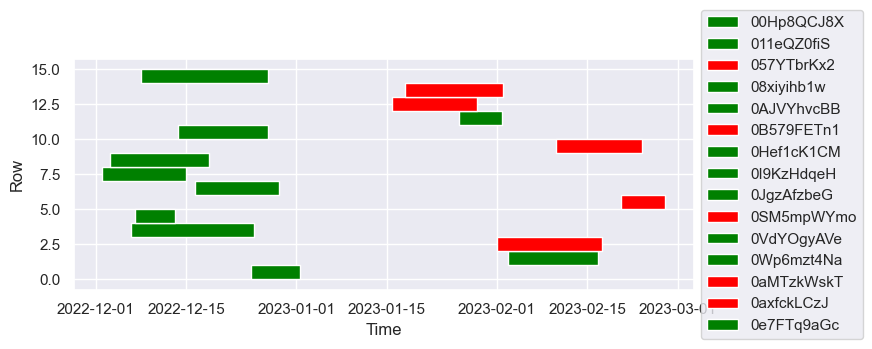

In [249]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green', highlight_ids=chosen_ids, highlight_color='red')